In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt
import cmath
plt.style.use('paper.mplstyle')

In [2]:
%run helper_function.ipynb

In [3]:
def breathingON(mass, alpha, A1_off):
    chi12, chi23 = calcChi(mass,alpha)
    if chi12 > 1/2:
        phi = np.arccos((1-2*chi12)/(2*chi12))
    else:
        phi = np.arccos(-(1-2*chi12)/(2*chi12))
    A2_on = A1_off/np.sqrt(chi12)
    A1_on = np.sqrt(chi12)*A1_off
    return A1_on, A2_on, phi

In [4]:
# calculate the closest j-k:j
def closest(num, arr):
    index = 0
    curr = arr[0]
    for i, value in enumerate(arr):
        if abs(num-value) < abs(num-curr):
            curr = value
            index = i
    return index

def calcParam(alpha12):
    P_ratio = alpha12**(3/2)
    true_ratio = [(j-k)/j for j in np.arange(4,15) for k in np.arange(1,3)]
    ref = [[j,k] for j in np.arange(4,15) for k in np.arange(1,3)]
    index = closest(P_ratio, true_ratio)
    return ref[index]

In [5]:
MASS = 4e-5, 1e-15, 8e-4
timescale = 1e8
P3 = 3.2

In [6]:
def simNoBreathing(parameters):
    alpha12, te12 = parameters
    P1, P2 = 1, alpha12**(-3/2)
    alpha = alpha12, (P2/P3)**(2/3)
    ecc_nb, pomega_nb = AtoE(alpha, MASS, (te12*(1-alpha12), 0, 0), (0, 0, 0))
    
    j, k = calcParam(alpha12)[0], calcParam(alpha12)[1]
    Lambda = 1, (k*(pomega_nb[1]-pomega_nb[0]) + np.pi + (j-k))/j, 0
    sim = make_sim(alpha, MASS, ecc_nb, pomega_nb, Lambda)
    ps = sim.particles
    
    sim.init_megno()
    Nout = 2000
    times = np.linspace(0,timescale, Nout)
    e12, e23 = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            e1x, e2x, e3x = ps[1].e*np.cos(ps[1].pomega), ps[2].e*np.cos(ps[2].pomega), ps[3].e*np.cos(ps[3].pomega)
            e1y, e2y, e3y = ps[1].e*np.sin(ps[1].pomega), ps[2].e*np.sin(ps[2].pomega), ps[3].e*np.sin(ps[3].pomega)
            e12[i] = np.sqrt((e2x-e1x)**2+(e2y-e1y)**2)
            e23[i] = np.sqrt((e3x-e2x)**2+(e3y-e2y)**2)
        except rebound.Collision:
            return 4000, max(e12)/(1-alpha12)
    return sim.calculate_megno(), max(e12)/(1-alpha12)

In [7]:
def simWithBreathing(parameters):
    alpha12, te12 = parameters
    P1, P2 = 1, alpha12**(-3/2)
    alpha = alpha12, (P2/P3)**(2/3)
    
    amp1_wb, amp2_wb, phi = breathingON(MASS, alpha, te12*(1-alpha12))
    ecc_wb, pomega_wb = AtoE(alpha, MASS, (amp1_wb, amp2_wb, 0), (0, phi, 0))
    
    j, k = calcParam(alpha12)[0], calcParam(alpha12)[1]
    Lambda = 1, (k*(pomega_wb[1]-pomega_wb[0]) + np.pi + (j-k))/j, 0
    sim = make_sim(alpha, MASS, ecc_wb, pomega_wb, Lambda)
    ps = sim.particles

    sim.init_megno()
    Nout = 2000
    times = np.linspace(0,timescale, Nout)
    e12, e23 = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            e1x, e2x, e3x = ps[1].e*np.cos(ps[1].pomega), ps[2].e*np.cos(ps[2].pomega), ps[3].e*np.cos(ps[3].pomega)
            e1y, e2y, e3y = ps[1].e*np.sin(ps[1].pomega), ps[2].e*np.sin(ps[2].pomega), ps[3].e*np.sin(ps[3].pomega)
            e12[i] = np.sqrt((e2x-e1x)**2+(e2y-e1y)**2)
            e23[i] = np.sqrt((e3x-e2x)**2+(e3y-e2y)**2)
        except rebound.Collision:
            return 4000, max(e12)/(1-alpha12)
    return sim.calculate_megno(), max(e12)/(1-alpha12)

In [8]:
Ngrid_x = 400
Ngrid_y = 400

P12s = np.linspace(2/3, 3/4, Ngrid_x)
alpha12 = np.array([x**(2/3) for x in P12s])
e12 = np.linspace(0.0,0.50,Ngrid_y)
parameters = [[x,y] for x in alpha12 for y in e12]

In [ ]:
%%time
pool = InterruptiblePool()
megno_nb, e12_nb = zip(*pool.map(simNoBreathing,parameters))
np.savetxt("./megno_nb.csv", megno_nb, delimiter=",")
np.savetxt("./e12_nb.csv", e12_nb, delimiter=",")

In [ ]:
%%time
pool = InterruptiblePool()
megno_wb, e12_wb = zip(*pool.map(simWithBreathing,parameters))
np.savetxt("./megno_wb.csv", megno_wb, delimiter=",")
np.savetxt("./e12_wb.csv", e12_wb, delimiter=",")

In [9]:
def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False

In [10]:
A, B = 1.38159886, -4.6164984  # the values come from a manual fit to where MMRs overlap
def bound_12(P12,P23,mass):  # see Hadden & Lithwick (2018)
    a12 = P12**(2/3)
    deltas = (1-P12**(2/3))/(mass[0]+mass[1])**(1/4)
    return A*np.exp(B*deltas**(-4/3))

def bound_12p(P12,P23,mass):
    a12, a23 = P12**(2/3), P23**(2/3)
    mu = mass[0]+mass[1]
    chi12, chi23 = calcChi(mass,(a12,a23))
    extent = 1/np.sqrt(chi12)
    
    deltas = (1-P12**(2/3))/(mu)**(1/4)
    return A*np.exp(B*deltas**(-4/3))/extent

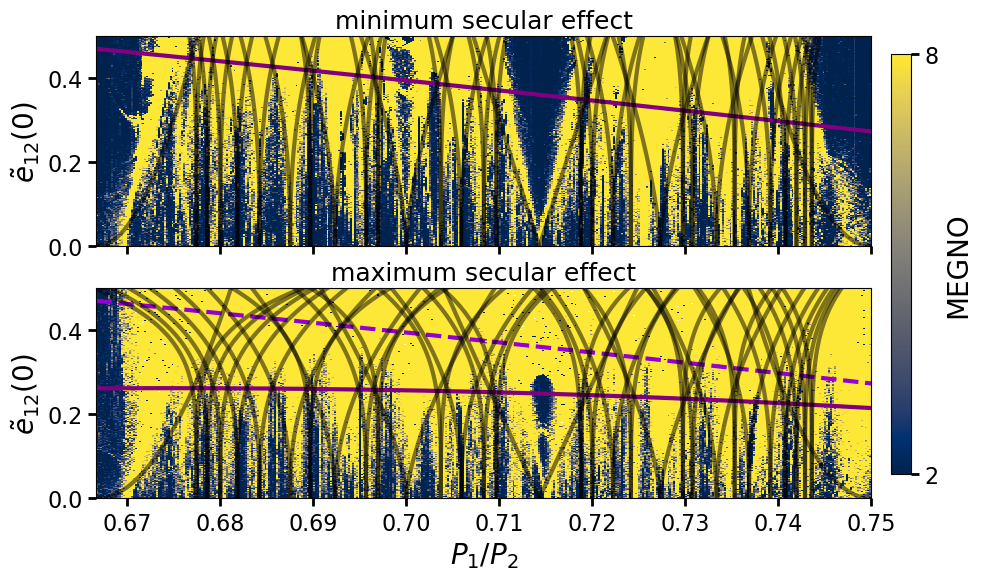

In [11]:
dataframe1 = pd.read_csv('./megno_nb.csv', header=None)
data_nb = (dataframe1.values).reshape(Ngrid_y,Ngrid_x)
dataframe2 = pd.read_csv('./megno_wb.csv', header=None)
data_wb = (dataframe2.values).reshape(Ngrid_y,Ngrid_x)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,6))
fig.subplots_adjust(wspace=0.2)

extent = [P12s.min(),P12s.max(),min(e12),max(e12)]
ax1.set_xlim(extent[0],extent[1])
ax1.set_ylim(extent[2],extent[3])
ax1.set_ylabel(r"$\tilde{e}_{12}(0)$")
ax1.set_title("minimum secular effect",fontsize=18)

ax2.set_xlim(extent[0],extent[1])
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlabel(r"$P_1/P_2$")
ax2.set_ylabel(r"$\tilde{e}_{12}(0)$")
ax2.set_title("maximum secular effect",fontsize=18)

bound1, bound2 = np.zeros(len(P12s)), np.zeros(len(P12s))
for i, p12 in enumerate(P12s):
    bound1[i] = bound_12(p12,1/p12/P3,MASS)
    bound2[i] = bound_12p(p12,1/p12/P3,MASS)
ax1.plot(P12s, bound1, color='purple', lw=3)
ax2.plot(P12s, bound1, color='darkviolet', linestyle='--',lw=3)
ax2.plot(P12s, bound2, color='purple', lw=3)

im1 = ax1.imshow(data_nb.transpose(), vmin=2, vmax=8, interpolation="none", cmap="cividis", rasterized=True, origin="lower", aspect='auto', extent=extent)
im2 = ax2.imshow(data_wb.transpose(), vmin=2, vmax=8, interpolation="none", cmap="cividis", rasterized=True, origin="lower", aspect='auto', extent=extent)

kmax=10
jmax=100
mu=MASS[0]+MASS[1]

h = np.ones(11)*0.4
h[1] = 0.535
h[2] = 0.426
h[3] = 0.420
h[4] = 0.454
h[5] = 0.519
h[6] = 0.613
h[7] = 0.742
h[8] = 0.914
h[9] = 1.143
h[10] = 1.445

f=1
for k in range(1,kmax+1):
    for j in range(2*k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            es = np.linspace(min(e12),max(e12), 100)
            dPs = (j/(j-k))*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*(es*f)**(k/2)
            ax1.plot(1/(P21+dPs), es, 'k', alpha=0.5)
            ax1.plot(1/(P21-dPs), es, 'k', alpha=0.5)


for k in range(1,kmax+1):
    for j in range(2*k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu*(1 + alpha**(1/6))
        
        chi12, chi23 = calcChi(MASS,(alpha,(P21/P3)**(2/3)))
        f = 1/np.sqrt(chi12)
        if P21 > 1/P12s.max()-0.01 and P21 < 1/P12s.min()+0.01:
            es = np.linspace(min(e12),max(e12), 100)
            dPs = (j/(j-k))*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*(es*f)**(k/2)
            ax2.plot(1/(P21+dPs), es, 'k', alpha=0.5)
            ax2.plot(1/(P21-dPs), es, 'k', alpha=0.5)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax,ticks=[2,8])
cbar.set_label("MEGNO")